In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")  

In [58]:
# Load and preprocess data
df = pd.read_csv("SE5.csv", parse_dates=["Time"])
df = df.sort_values(by="Time").reset_index(drop=True)

In [59]:
# Train-validation and test split
test = df[df["Time"] >= "2024-01-01"]
train_val = df[df["Time"] < "2024-01-01"]

X = train_val.drop(columns=["class"])
y = train_val["class"]
X_test = test.drop(columns=["class"])
y_test = test["class"]

In [60]:
# Function to calculate stability score
def stability_metrics(results_df, start_date, end_date):
    interval_df = results_df[
        (results_df["Time"] >= start_date) & (results_df["Time"] <= end_date)
    ]

    tp = len(interval_df[(interval_df["class"] == 1) & (interval_df["pred"] == 1)])
    fp = len(interval_df[(interval_df["class"] == 0) & (interval_df["pred"] == 1)])
    total_trades = len(interval_df)
    profitable_trades_n = len(interval_df[interval_df["class"] == 1])

    if total_trades == 0 or fp == 0 or profitable_trades_n == 0:
        return {"Stability Score": np.nan, "TP": tp, "FP": fp, "Profitable Trade %": 0}

    profitable_ratio = profitable_trades_n / total_trades
    stability = (tp / fp) / profitable_ratio

    return {
        "Stability Score": stability,
        "TP": tp,
        "FP": fp,
        "Profitable Trade %": profitable_ratio,
    }

In [61]:
# Cross-validation

folds = 5
cv_metrics = {
    "precision": list(),
    "recall": list(),
    "f1": list(),
    "Train Period": list(),
    "Valid Period": list(),
    "Stability Score": list()
}

tscv = TimeSeriesSplit(n_splits=folds)
for i, (train_idx, val_idx) in enumerate(tscv.split(X, y)):
    print(f"Fold {i + 1}")
    x_tr, x_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    train_start = x_tr['Time'].min()
    train_end = x_tr['Time'].max()
    val_start = x_va['Time'].min()
    val_end = x_va['Time'].max()

    interval_start_date = val_start
    interval_end_date = val_end

    cv_metrics["Train Period"].append(f"{train_start.strftime('%Y-%m')} - {train_end.strftime('%Y-%m')}")
    cv_metrics["Valid Period"].append(f"{val_start.strftime('%Y-%m')} - {val_end.strftime('%Y-%m')}")

    smote = SMOTE(random_state=1)
    X_train_resampled, y_train_resampled = smote.fit_resample(x_tr.drop(columns='Time'), y_tr)

    model = lgb.LGBMClassifier(random_state=1, scale_pos_weight=4)
    model.fit(X_train_resampled, y_train_resampled)

    y_val_pred = model.predict(x_va.drop(columns='Time'))

    # Collect validation metrics
    cv_metrics["precision"].append(precision_score(y_va, y_val_pred))
    cv_metrics["recall"].append(recall_score(y_va, y_val_pred))
    cv_metrics["f1"].append(f1_score(y_va, y_val_pred))

    temp_val_df = x_va
    temp_val_df['pred'] = y_val_pred
    temp_val_df['class'] = y_va


    stability_dict = stability_metrics(temp_val_df, interval_start_date, interval_end_date)
    cv_metrics['Stability Score'].append(stability_dict['Stability Score'])
    

Fold 1
[LightGBM] [Info] Number of positive: 5345, number of negative: 5345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73386
[LightGBM] [Info] Number of data points in the train set: 10690, number of used features: 685
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 2
[LightGBM] [Info] Number of positive: 10684, number of negative: 10684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73495
[LightGBM] [Info] Number of data points in the train set: 21368, number of used features: 695
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 3
[LightGBM] [Info] Number of positive: 16101, number of negative: 16101
[LightGBM] [Info] Auto-choos

In [62]:
cv_results_df = pd.DataFrame(
    {
        "Train Period": cv_metrics["Train Period"],
        "Valid Period": cv_metrics["Valid Period"],
        "Precision": cv_metrics["precision"],
        "Recall": cv_metrics["recall"],
        "F1": cv_metrics["f1"],
        "Stability": cv_metrics['Stability Score']
    }
)
cv_results_df

,Train Period,Valid Period,Precision,Recall,F1,Stability
0,2008-01 - 2010-05,2010-05 - 2012-07,0.204692,0.301695,0.243902,1.188982
1,2008-01 - 2012-07,2012-07 - 2015-08,0.195402,0.243379,0.216768,1.184559
2,2008-01 - 2015-08,2015-08 - 2018-07,0.158473,0.213729,0.181999,1.000925
3,2008-01 - 2018-07,2018-07 - 2021-03,0.195743,0.291122,0.234090,1.141372
4,2008-01 - 2021-03,2021-03 - 2023-12,0.213565,0.466253,0.292947,1.274389


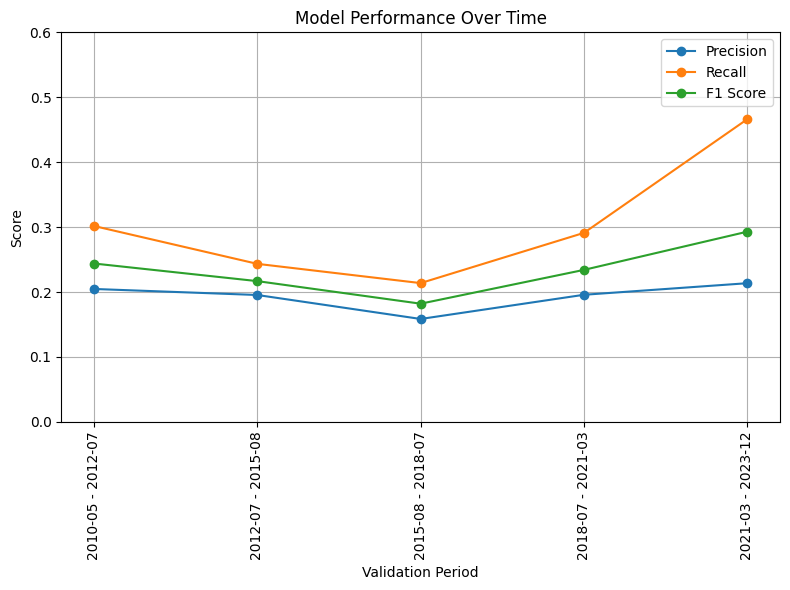

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results_df["Valid Period"], cv_results_df["Precision"], marker='o', label="Precision")
plt.plot(cv_results_df["Valid Period"], cv_results_df["Recall"], marker='o', label="Recall")
plt.plot(cv_results_df["Valid Period"], cv_results_df["F1"], marker='o', label="F1 Score")
# plt.plot(cv_results_df["Valid Period"], cv_results_df["Stability"], marker='o', label="Stability")

plt.xlabel("Validation Period")
plt.ylabel("Score")
plt.title("Model Performance Over Time")
plt.xticks(rotation=90)
plt.ylim(0, 0.6)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
start_date, end_date = '2024-01-01', '2024-12-31'
X_test_sliced = X_test[(X_test['Time']>=start_date) & (X_test['Time']<=end_date)].drop(columns='Time')
y_test_sliced = test[(test['Time']>=start_date) & (test['Time']<=end_date)]['class']

In [65]:
# Testing on unseen data

smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X.drop(columns='Time'), y)

model = lgb.LGBMClassifier(random_state=1, scale_pos_weight=4)
model.fit(X_train_resampled, y_train_resampled)

y_test_pred = model.predict(X_test_sliced)


[LightGBM] [Info] Number of positive: 32356, number of negative: 32356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73582
[LightGBM] [Info] Number of data points in the train set: 64712, number of used features: 703
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [66]:
# Evaluate on test set
test_metrics = {
    "precision": precision_score(y_test_sliced, y_test_pred),
    "recall": recall_score(y_test_sliced, y_test_pred),
    "f1": f1_score(y_test_sliced, y_test_pred),
}
test_metrics

{'precision': 0.1669902912621359,
 'recall': 0.4028103044496487,
 'f1': 0.2361015785861359}

In [67]:
# Stability metric
results = test[(test['Time']>=start_date) & (test['Time']<=end_date)]
results["pred"] = y_test_pred
st_metrics = stability_metrics(results_df=results, start_date=start_date, end_date=end_date)

In [68]:
print("\nFinal Test Set Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nStability Metrics (2024 Q1):")
for key, value in st_metrics.items():
    print(f"{key}: {value}")



Final Test Set Metrics:
precision: 0.1670
recall: 0.4028
f1: 0.2361

Stability Metrics (2024 Q1):
Stability Score: 1.0858977088485284
TP: 172
FP: 858
Profitable Trade %: 0.18460873324686555
